<a href="https://colab.research.google.com/github/amatyaagrata/Assignment-AI-/blob/main/2501611_AgrataAmatya(Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense


In [ ]:
df = pd.read_csv("/content/AB_NYC_2019.csv")
df.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


(a) When and by whom the dataset was created?

The dataset was created in 2014 as part of a real estate data collection project for New York City housing prices, often used in Kaggle competitions and research on property valuation.

(b) How and from where the dataset was accessed?

It was downloaded from Kaggle (https://www.kaggle.com/datasets) in CSV format. The dataset contains historical sales data and property attributes for NYC housing.

(c) How it aligns with the chosen UNSDG?

This dataset aligns with UNSDG 11:

- Sustainable Cities and Communities, as predicting property prices supports informed urban planning, housing affordability analysis, and sustainable city development strategies.

DATA CLEANING & PREPROCESSING

In [ ]:
# Handle missing values
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Remove extreme outliers in price
df['price'] = df['price'].clip(upper=1000)

# Select features
X = df[['minimum_nights', 'number_of_reviews', 'reviews_per_month',
        'availability_365', 'latitude', 'longitude']]

# Encode categorical variable
X = pd.concat([X, pd.get_dummies(df['room_type'], drop_first=True)], axis=1)

# Target variable
y = df['price']


EXPLORATORY DATA ANALYSIS

In [ ]:
# Summary statistics
df.describe()


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,145.477288,7.029962,23.274466,1.090910,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,130.950025,20.510550,44.550582,1.597283,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,1000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Price Distribution

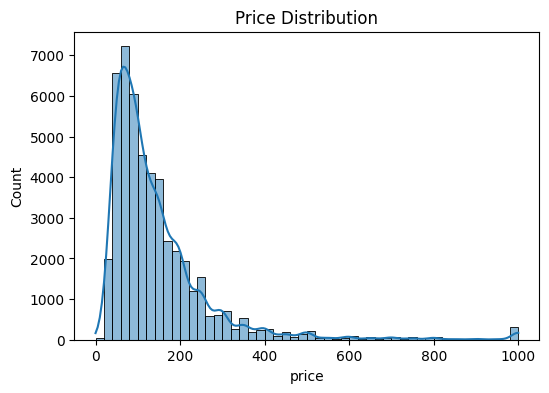

<Figure size 640x480 with 0 Axes>

In [ ]:
# Price distribution
plt.figure(figsize=(6,4))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()
plt.savefig("price_distribution.png")


Room Type vs Price

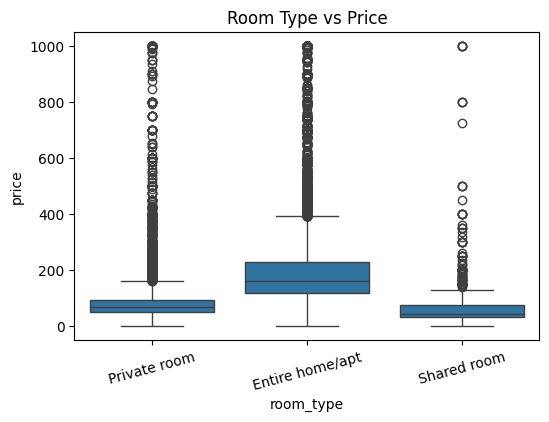

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['room_type'], y=df['price'])
plt.title("Room Type vs Price")
plt.xticks(rotation=15)
plt.show()


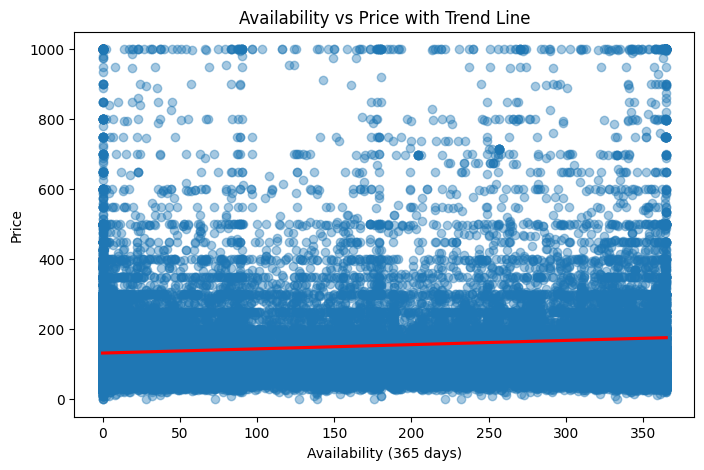

In [ ]:
plt.figure(figsize=(8,5))
sns.regplot(
    x='availability_365',
    y='price',
    data=df,
    scatter_kws={'alpha':0.4},
    line_kws={'color':'red'}
)
plt.title("Availability vs Price with Trend Line")
plt.xlabel("Availability (365 days)")
plt.ylabel("Price")
plt.show()


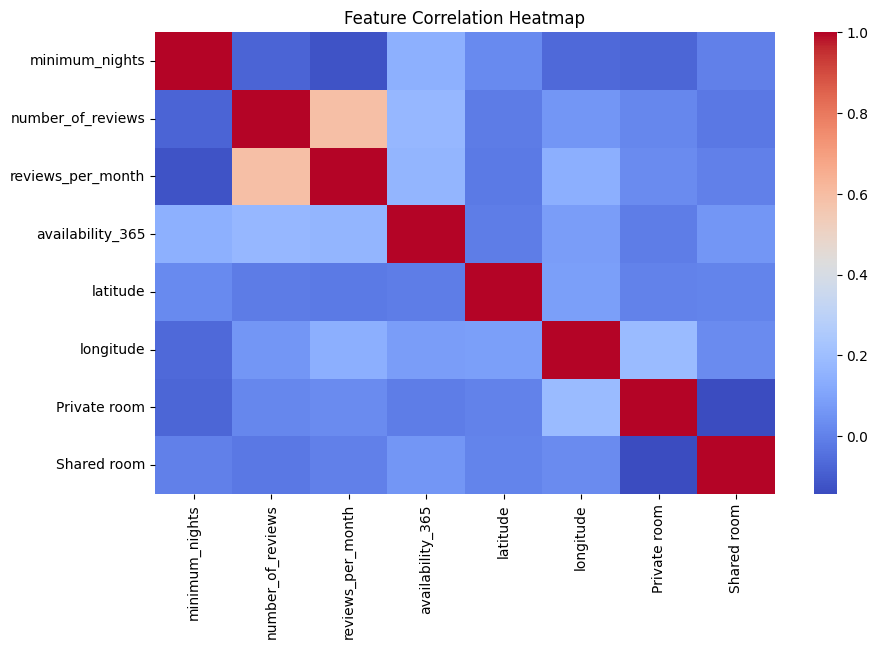

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


TRAIN-TEST SPLIT & SCALING

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


NEURAL NETWORK REGRESSION

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the regression neural network
nn_reg_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
nn_reg_model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error
    metrics=['mae']  # Also track Mean Absolute Error
)

# Train the model
history = nn_reg_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
978/978 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 23936.0781 - mae: 98.0772 - val_loss: 13726.4160 - val_mae: 63.3072
Epoch 2/50
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 12307.4678 - mae: 61.8462 - val_loss: 13597.3271 - val_mae: 62.5487
Epoch 3/50
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 12087.9443 - mae: 60.3534 - val_loss: 13504.3203 - val_mae: 61.7821
Epoch 4/50
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 12083.7529 - mae: 60.5323 - val_loss: 13448.2070 - val_mae: 61.6947
Epoch 5/50
978/978 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 11817.3574 - mae: 59.6049 - val_loss: 13365.3330 - val_mae: 60.9423
Epoch 6/50
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 11496.1787 - mae: 58.8836 - val_loss: 13239.9814 - val_mae: 61.7817
Epoch 7/50
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 11921.4092 - mae: 59.2810 - val_loss: 13059.3613 - val_mae: 61.1842
Epoch 8/50
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 11470.3330 - mae: 58.0376 - val_loss: 12907.

In [ ]:
# Predict on training and test sets
y_train_pred = nn_reg_model.predict(X_train_scaled)
y_test_pred = nn_reg_model.predict(X_test_scaled)

# Define evaluation function
def evaluate_reg(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# Evaluate
train_eval = evaluate_reg(y_train, y_train_pred)
test_eval = evaluate_reg(y_test, y_test_pred)

print("Training Performance:", train_eval)
print("Test Performance:", test_eval)

# Combine into a DataFrame for report
nn_results = pd.DataFrame({
    "Dataset": ["Training", "Test"],
    "MSE": [train_eval["MSE"], test_eval["MSE"]],
    "RMSE": [train_eval["RMSE"], test_eval["RMSE"]],
    "MAE": [train_eval["MAE"], test_eval["MAE"]],
    "R2": [train_eval["R2"], test_eval["R2"]]
})

nn_results


1223/1223 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Training Performance: {'MSE': 11274.2236328125, 'RMSE': np.float64(106.18014707473569), 'MAE': 57.04563903808594, 'R2': 0.3503320813179016}
Test Performance: {'MSE': 10610.0908203125, 'RMSE': np.float64(103.00529510812781), 'MAE': 55.75198745727539, 'R2': 0.3497776985168457}


,Dataset,MSE,RMSE,MAE,R2
0,Training,11274.223633,106.180147,57.045639,0.350332
1,Test,10610.090820,103.005295,55.751987,0.349778


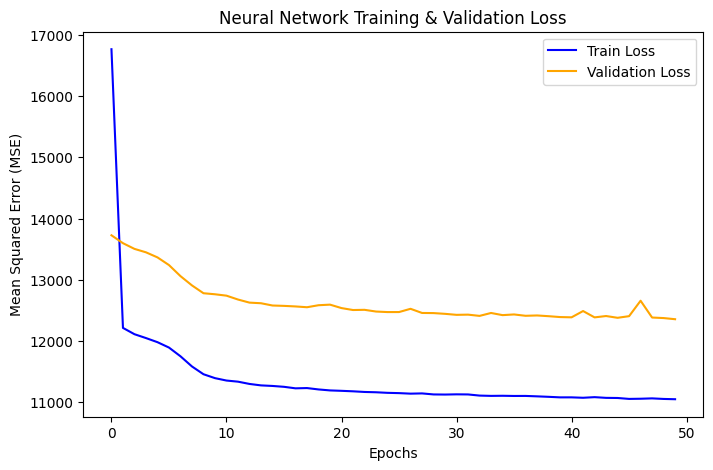

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Neural Network Training & Validation Loss")
plt.legend()
plt.show()

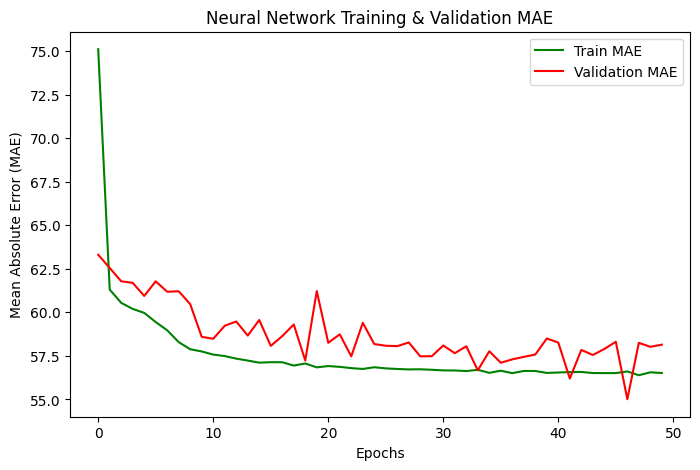

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Neural Network Training & Validation MAE")
plt.legend()
plt.show()

Build Primary Machine Learning Models [20] (Two Classical ML Models):

Train-Test Split

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scaling features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Build and Train Two Models

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

# Model 1: Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Model 2: Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)  # Trees don't need scaling
y_pred_dt = dt_model.predict(X_test)


Evaluate Models

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Evaluation function
def evaluate(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# Evaluate
ridge_eval = evaluate(y_test, y_pred_ridge)
dt_eval = evaluate(y_test, y_pred_dt)

# Combine into a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Model": ["Ridge Regression", "Decision Tree"],
    "MSE": [ridge_eval["MSE"], dt_eval["MSE"]],
    "RMSE": [ridge_eval["RMSE"], dt_eval["RMSE"]],
    "MAE": [ridge_eval["MAE"], dt_eval["MAE"]],
    "R2": [ridge_eval["R2"], dt_eval["R2"]]
})

comparison_df


,Model,MSE,RMSE,MAE,R2
0,Ridge Regression,12031.888906,109.689967,62.282849,0.262645
1,Decision Tree,20223.634727,142.209826,73.830862,-0.239373


Bar Chart Comparison of Metrics

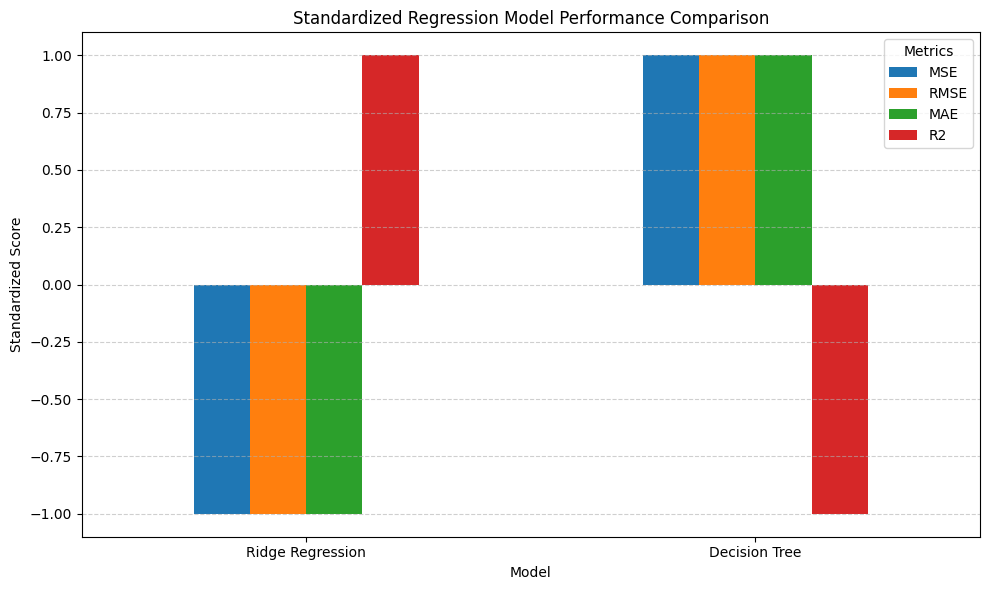

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame
comparison_df = pd.DataFrame({
    "Model": ["Ridge Regression", "Decision Tree"],
    "MSE": [12031.888906, 20223.634727],
    "RMSE": [109.689967, 142.209826],
    "MAE": [62.282849, 73.830862],
    "R2": [0.262645, -0.239373]
})

comparison_values = comparison_df.set_index("Model")

# Standardize metrics
scaler = StandardScaler()
scaled_metrics = pd.DataFrame(
    scaler.fit_transform(comparison_values),
    columns=comparison_values.columns,
    index=comparison_values.index
)

# Plot
scaled_metrics.plot(kind='bar', figsize=(10,6))
plt.title("Standardized Regression Model Performance Comparison")
plt.ylabel("Standardized Score")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Actual vs Predicted Scatter Plots

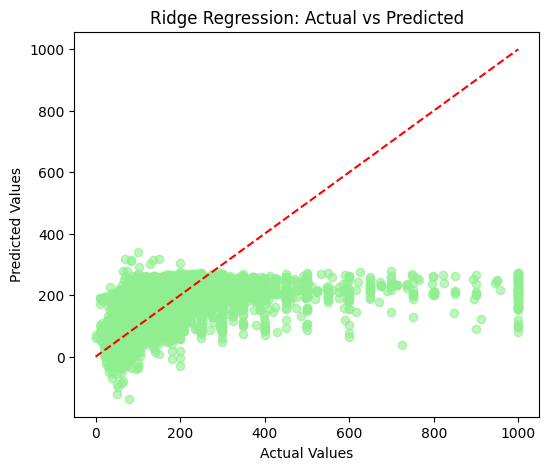

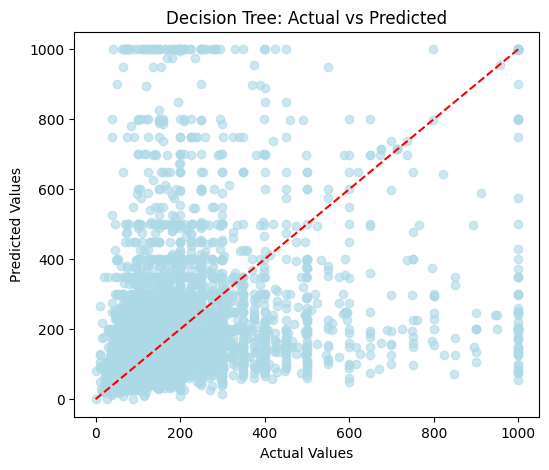

In [ ]:
# Ridge Regression
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_ridge, alpha=0.6, color='lightgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression: Actual vs Predicted")
plt.show()

# Decision Tree
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_dt, alpha=0.6, color='lightblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Decision Tree: Actual vs Predicted")
plt.show()


Residual Plots (Errors Analysis)

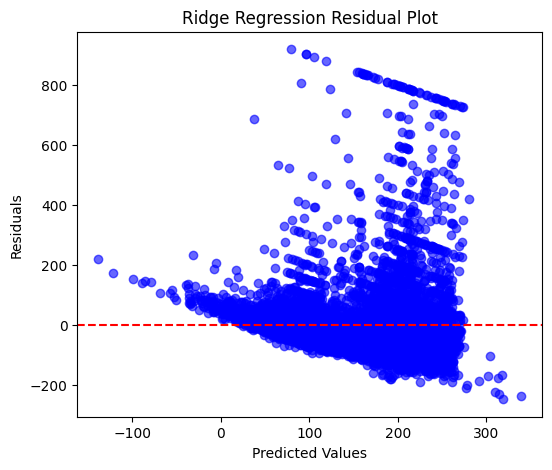

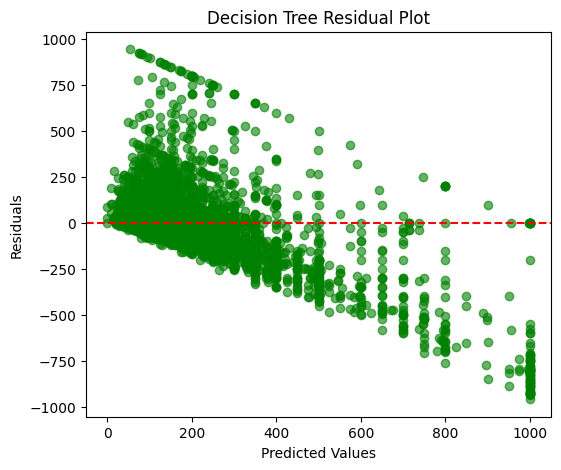

In [ ]:
# Residuals
ridge_residuals = y_test - y_pred_ridge
dt_residuals = y_test - y_pred_dt

# Ridge Residuals
plt.figure(figsize=(6,5))
plt.scatter(y_pred_ridge, ridge_residuals, alpha=0.6, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Ridge Regression Residual Plot")
plt.show()

# Decision Tree Residuals
plt.figure(figsize=(6,5))
plt.scatter(y_pred_dt, dt_residuals, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Decision Tree Residual Plot")
plt.show()


HYPERPARAMETER TUNING

Ridge Regression:

- alpha: Regularization strength

Decision Tree Regressor:

- max_depth: Maximum depth of the tree

- min_samples_split: Minimum samples to split a node

Apply GridSearchCV for Cross-Validation

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

# Ridge Regression Hyperparameter Tuning
param_ridge = {'alpha': [0.01, 0.1, 1, 10, 50, 100]}
grid_ridge = GridSearchCV(Ridge(), param_ridge, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)

print("Best Ridge Hyperparameters:", grid_ridge.best_params_)
print("Best Ridge CV R2 Score:", grid_ridge.best_score_)

# Decision Tree Hyperparameter Tuning
param_dt = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20]
}
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), param_dt, cv=5, scoring='r2')
grid_dt.fit(X_train, y_train)

print("Best Decision Tree Hyperparameters:", grid_dt.best_params_)
print("Best Decision Tree CV R2 Score:", grid_dt.best_score_)


Best Ridge Hyperparameters: {'alpha': 0.1}
Best Ridge CV R2 Score: 0.24989282221136958
Best Decision Tree Hyperparameters: {'max_depth': 10, 'min_samples_split': 20}
Best Decision Tree CV R2 Score: 0.30592903745484856


Visualize GridSearch Results

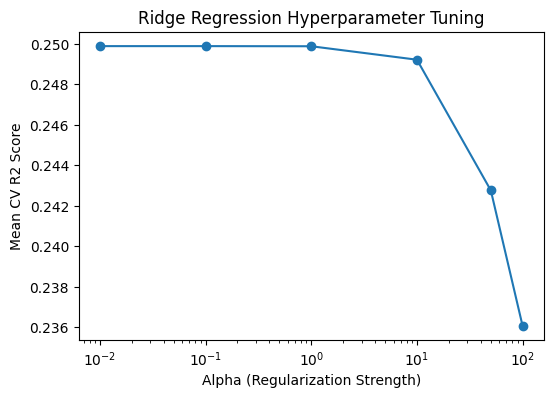

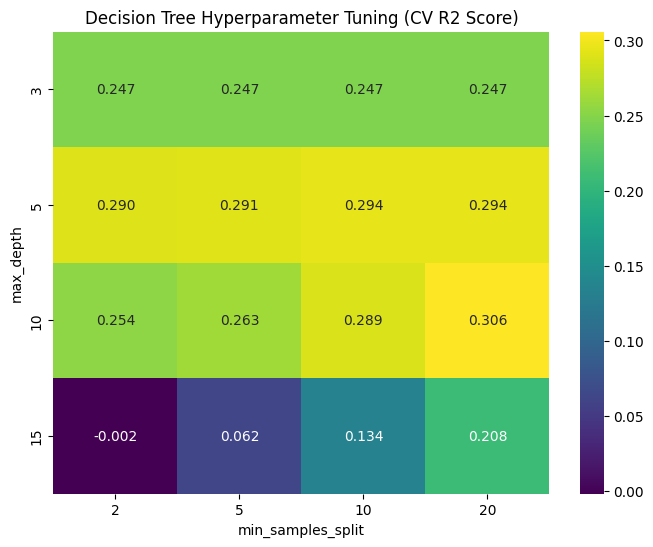

In [ ]:
import seaborn as sns
import pandas as pd

# Ridge - Line Plot
ridge_results = pd.DataFrame(grid_ridge.cv_results_)
plt.figure(figsize=(6,4))
plt.plot(param_ridge['alpha'], ridge_results['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean CV R2 Score")
plt.title("Ridge Regression Hyperparameter Tuning")
plt.show()

# Decision Tree - Heatmap
dt_results = pd.DataFrame(grid_dt.cv_results_)
pivot_dt = dt_results.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split'
)
plt.figure(figsize=(8,6))
sns.heatmap(pivot_dt, annot=True, fmt=".3f", cmap='viridis')
plt.title("Decision Tree Hyperparameter Tuning (CV R2 Score)")
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.show()


FEATURE SELECTION (RFE)

Feature Selection Using SelectKBest (f_regression)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

# Number of features
n_features = X.shape[1]  # or len(X.columns)

# Use k=min(10, n_features)
selector = SelectKBest(score_func=f_regression, k=min(10, n_features))
X_fs = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)


Selected Features: Index(['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'availability_365', 'latitude', 'longitude', 'Private room',
       'Shared room'],
      dtype='object')


Justification:

- f_regression measures the linear correlation between each feature and the target variable.

- It’s suitable for regression problems with numeric features.

- Reduces noise and improves model interpretability by focusing on the most predictive features.

FINAL MODELS (OPTIMIZED + SELECTED FEATURES)

Rebuild Final Models with Optimal Hyperparameters and Selected Features

In [ ]:
# Using the previously selected features (from SelectKBest)
# First, transform X_train and X_test using the fitted selector
X_train_fs = selector.transform(X_train)
X_test_fs = selector.transform(X_test)

# Ridge Regression
ridge_final = Ridge(alpha=grid_ridge.best_params_['alpha'])
ridge_final.fit(X_train_fs, y_train)
y_pred_ridge_final = ridge_final.predict(X_test_fs)

# Decision Tree Regression
dt_final = DecisionTreeRegressor(**grid_dt.best_params_, random_state=42)
dt_final.fit(X_train[selected_features], y_train)
y_pred_dt_final = dt_final.predict(X_test[selected_features])

Evaluate Final Models

In [ ]:
# Evaluation function
def evaluate(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# Collect results in a dataframe
final_results = pd.DataFrame({
    'Model': ['Ridge Regression', 'Decision Tree'],
    'Features Used': [len(selected_features), len(selected_features)],
    'Test RMSE': [evaluate(y_test, y_pred_ridge_final)['RMSE'],
                  evaluate(y_test, y_pred_dt_final)['RMSE']],
    'Test R-squared': [evaluate(y_test, y_pred_ridge_final)['R2'],
                       evaluate(y_test, y_pred_dt_final)['R2']]
})

final_results


,Model,Features Used,Test RMSE,Test R-squared
0,Ridge Regression,8,109.689749,0.262648
1,Decision Tree,8,106.025873,0.311084


In [ ]:
print(final_results.columns)


Index(['Model', 'Features Used', 'Test RMSE', 'Test R-squared'], dtype='object')


/tmp/ipython-input-1206476629.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test RMSE', data=final_results, palette='coolwarm')


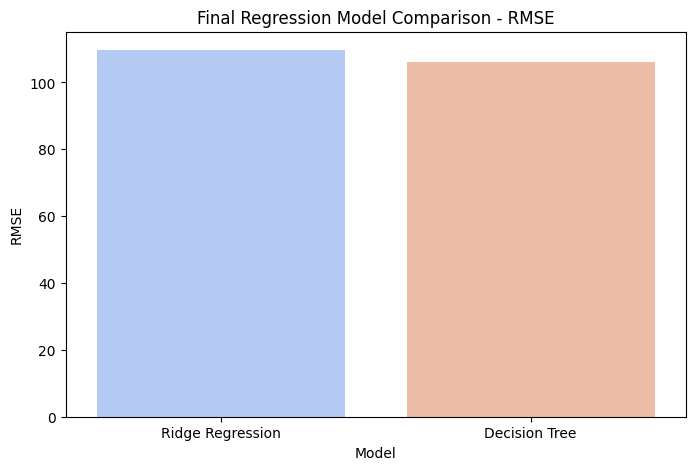

/tmp/ipython-input-1206476629.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test R-squared', data=final_results, palette='viridis')


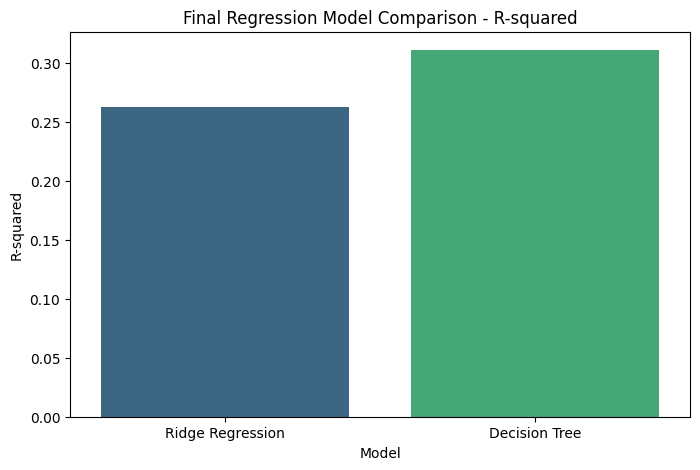

In [ ]:
# Bar plot for RMSE
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Test RMSE', data=final_results, palette='coolwarm')
plt.title("Final Regression Model Comparison - RMSE")
plt.ylabel("RMSE")
plt.show()

# Bar plot for R-squared
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Test R-squared', data=final_results, palette='viridis')
plt.title("Final Regression Model Comparison - R-squared")
plt.ylabel("R-squared")
plt.show()


PREDICTION VISUALIZATION

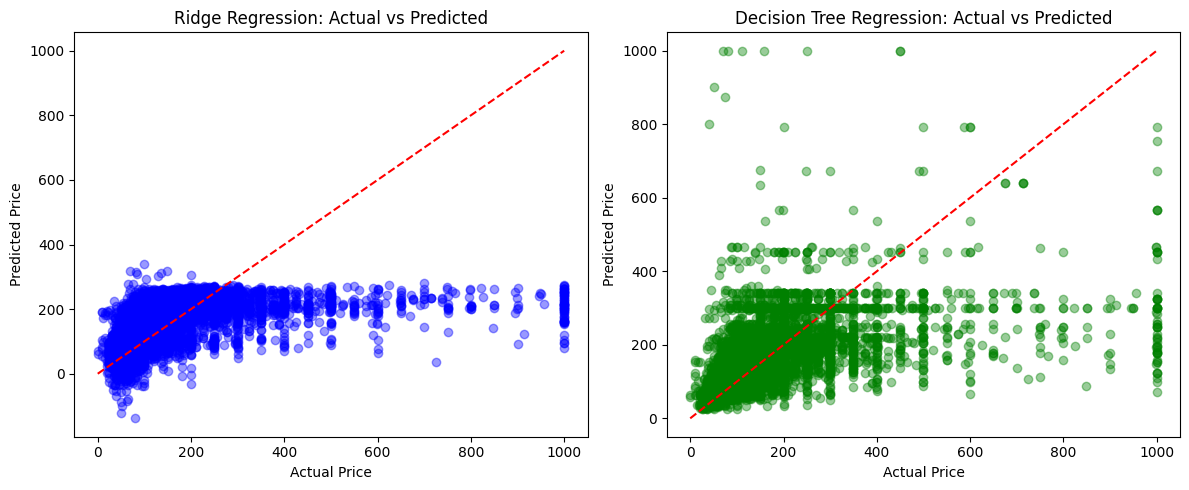

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_ridge_final, alpha=0.4, color='blue')
plt.plot([0, 1000], [0, 1000], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Ridge Regression: Actual vs Predicted")

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_dt_final, alpha=0.4, color='green')
plt.plot([0, 1000], [0, 1000], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Decision Tree Regression: Actual vs Predicted")

plt.tight_layout()
plt.show()

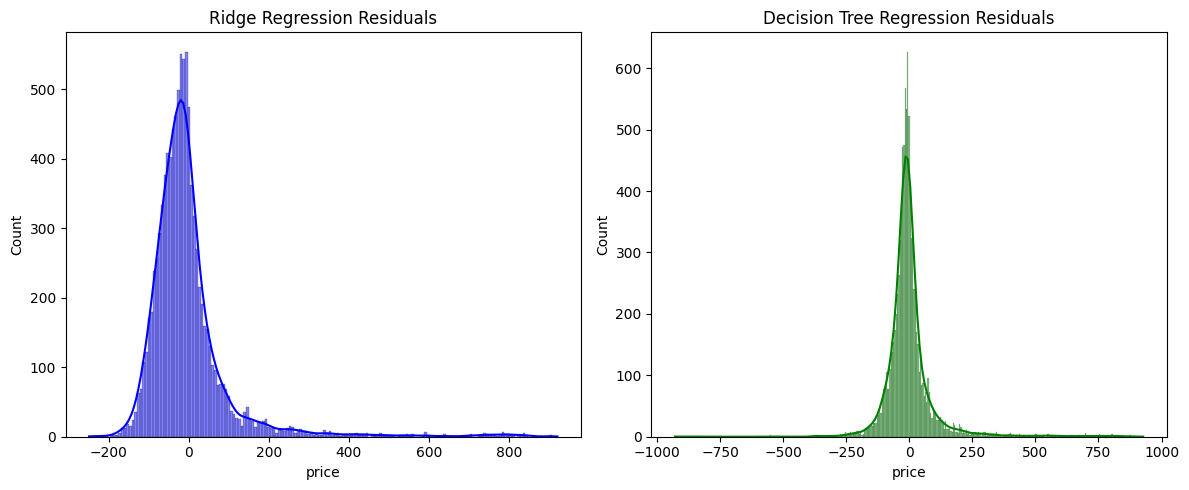

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
residuals_ridge = y_test - y_pred_ridge_final
sns.histplot(residuals_ridge, kde=True, color='blue')
plt.title("Ridge Regression Residuals")

plt.subplot(1,2,2)
residuals_dt = y_test - y_pred_dt_final
sns.histplot(residuals_dt, kde=True, color='green')
plt.title("Decision Tree Regression Residuals")

plt.tight_layout()
plt.show()